In [1]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.segmentation import clear_border
from skimage import measure
from skimage.measure import label,regionprops
from scipy import ndimage as ndi
from scipy.ndimage import measurements, center_of_mass, binary_dilation, zoom
import plotly.graph_objects as go

[[-1024. -1024. -1024. ... -1024. -1024. -1024.]
 [-1024. -1024.  -977. ... -1024. -1024. -1024.]
 [-1024. -1014.  -989. ... -1024. -1024. -1024.]
 ...
 [-1024. -1015. -1010. ... -1024. -1024. -1024.]
 [-1024. -1024.  -987. ... -1024. -1024. -1024.]
 [-1024. -1024. -1024. ... -1024. -1024. -1024.]]
(313, 512, 512)


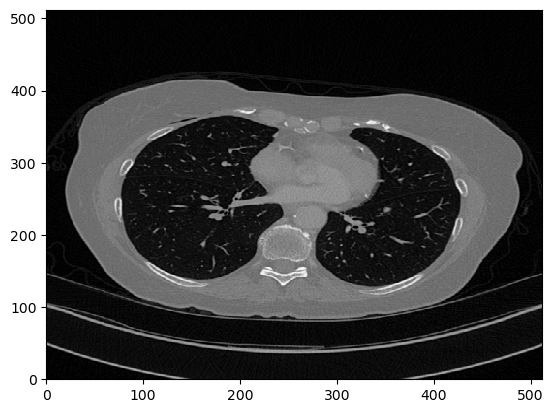

In [2]:
# A NIfTI fájllal kapcsolatos műveleteket tartalmazó könyvtár
import nibabel as nib

# A többdimenziós tömbök hatékony használatát teszi lehetővé a könyvtár
import numpy as np

# A tüdő fájl beolvasása a nibabel segítségével
img = nib.load('lung_089.nii').get_fdata()

# A tüdőt fentről szemlélve és felülnézetből értelmezve vizsgáljuk meg
# Rendezzük a tüdő dimenzióit
img = np.transpose(img, (2, 1, 0))

# Egy tűdő szelet értékei
print(img[140])

# A 3D-s kép alakja
print(img.shape)

# Adatvizualizációs könyvtár
import matplotlib.pyplot as plt

# A 140. kép szelet megjelenítése
plt.pcolormesh(img[140], cmap='Greys_r')

Open data

Plot slice of the image:

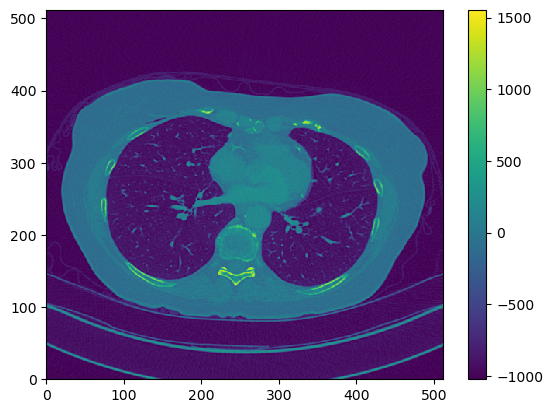

In [4]:
# A 140. kép szelet megjelenítése színesben
plt.pcolormesh(img[140])

# Színtartomány oszlop megjelenítése
plt.colorbar()

What do these units mean? The pixel values of this CT scan are expressed in Hounsfield Units

$$HU(x,y) \equiv 1000 \cdot \frac{\mu(x,y) - \mu_{\text{water}}}{\mu_{\text{water}}-\mu_\text{air}}$$

where $\mu$ is the linear attenuation coefficient of the material. The linear attenuation coefficient is defined based on how the intensity of a photon beam decays as it passes a distance $x$ through a material $I=I_0e^{-\mu x}$. Note that $\mu$ depends on the energy of the photon beam, and in a CT scan photons usually have energies $\approx 100$keV. Here are typical HU values:

<p align="center">
  <img src="../images/HU.PNG" alt="drawing" width="600" align="center"/>
</p>

# Modify data

The first thing to note is that air is signifcantly less HU than other substances in the body, so we apply a so-called "threshhold" mask. Lets use -320 HU as the lower limit:

In [5]:
# Megadunk egy küszöbértéket, amely segít eldönteni hogy egy adott pixel az levegő-e
threshhold = -320

# A kép pixelértékeit bináris értékre állítjuk úgy, hogy egy küszöbérték segítségével meghatározzuk, 
# hogy az egyes pixelek milyen bináris értéket vegyenek fel (igaz vagy hamis).
mask = img < threshhold

mask.shape

(313, 512, 512)

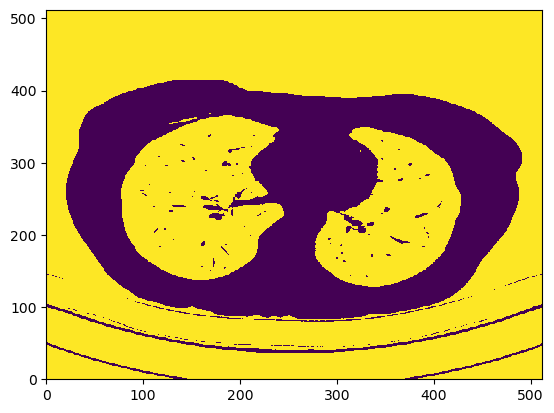

In [6]:
plt.pcolormesh(mask[140])

Next we can use the `clear_border` function to remove the outer border:

(313, 512, 512)

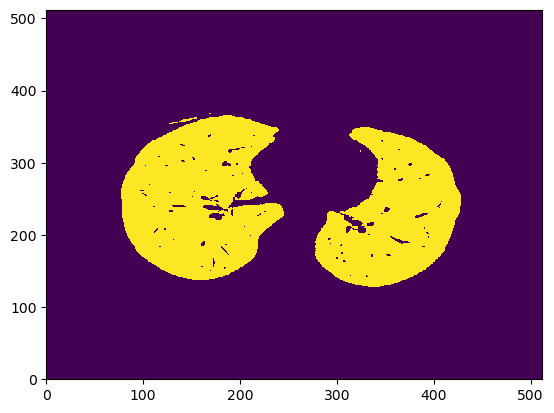

In [7]:
# A clear_border függvény eltűntetti a képben található külső határt
from skimage.segmentation import clear_border

# Alkalmazzuk a clear_border minden egyes kép szeletre
mask = np.vectorize(clear_border, signature='(n,m)->(n,m)')(mask)

# Kirajzoljuk az egyik szeletet
plt.pcolormesh(mask[140])

mask.shape

Now we'll give each seperate volume a different integer value using the `label` function

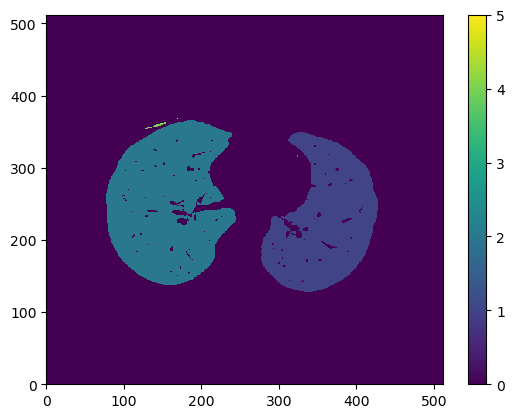

In [8]:
from skimage.measure import label

# Az egyes képszeleten megcímkézük számazonosítóval az összefüggő területeket
mask_labeled = np.vectorize(label, signature='(n,m)->(n,m)')(mask)

plt.pcolormesh(mask_labeled[140])
plt.colorbar()

Only consider the 2 largest lung areas (iterating though `idxs`). Add these areas to a new slice called `new_slc`:

Plot 

In [26]:
# new_slc = np.zeros_like(mask_labeled[140])
# rps = regionprops(mask_labeled[140])
# areas = [r.area for r in rps]
# areas[0].c

[20317.0, 26843.0, 2.0, 63.0, 2.0]

Now lets automate this for all slices in our 3D image:

In [10]:
# Tudományos képfeldolgozásra használt könyvtár
from skimage.measure import regionprops

# Egy kép szeleten meghatározza a 2 legnagyobb területet 
def keep_top_2(slc):
    
    # Kigyüjtjük a képen található régiókat az rps listába
    rps = regionprops(slc)
    
    # Kigyüjtjük a régiók terület méreteit az areas listába
    areas = [r.area for r in rps]
    
    # Az régió azonosítokat csökkenő sorrenbe helyezzük a területi méretük szerint
    idxs = np.argsort(areas)[::-1]
    
    # Létrehozzunk egy üres képet, lemásoljuk a kép felbontását
    new_slc = np.zeros_like(slc)
    
    # Berakjuk a két legnagyobb területetű régiokat a képbe
    for i in idxs[:2]:
        # Az régiónak az összes pixel koordinátáját beállítjuk 1-re
        new_slc[tuple(rps[i].coords.T)] = 1
        
    return new_slc

In [11]:
# Az összes szeletetnél csak a 2 legnagyobb területet tarjuk meg
mask= np.vectorize(keep_top_2, signature='(n,m)->(n,m)')(mask_labeled)

<Figure size 800x800 with 0 Axes>

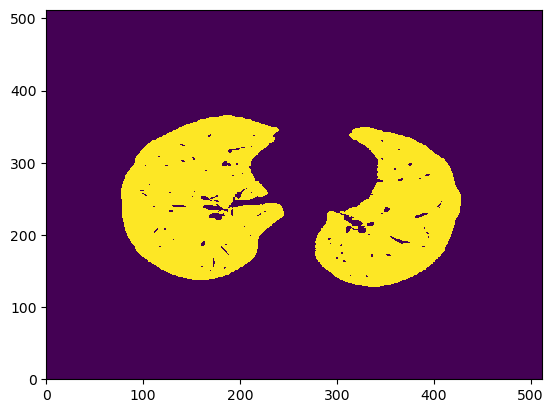

<Figure size 800x800 with 0 Axes>

In [12]:
plt.pcolormesh(mask[140])
plt.figure(figsize=(8,8))


Now lets fill in any small holes in the lungs:

In [13]:
# Számos matematikai és tudományos algoritmust kínáló könyvtár
from scipy import ndimage as ndi

# Az összes szeleteten kitöltjük a lyukakat
mask = np.vectorize(ndi.binary_fill_holes, signature='(n,m)->(n,m)')(mask)

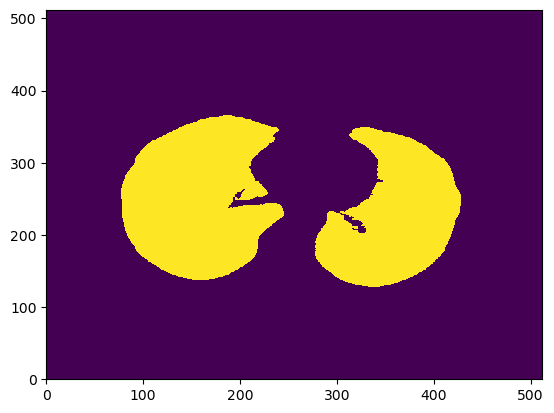

In [30]:
plt.pcolormesh(mask[140])

In some slices, the trachea is kind of annoying and we need to remove it:

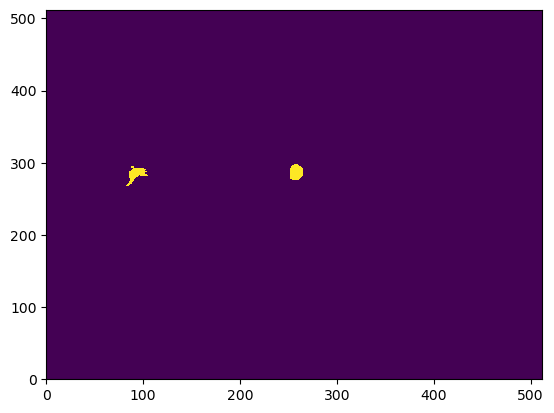

In [15]:
plt.pcolormesh(mask[-5])

In a 512x512 image, the trachea typically takes up less than 0.69% of the area. We can delete all regions that have any area smaller than this percentage:

In [16]:
# # Lemásoljuk az eredeti képet
# new_slc = mask[-10].copy() 

# # Megcímezzük az egyes régókat egy számazonosítóval
# labels = label(mask[-10],connectivity=1,background=0)

# # Kigyűjtjük a képen található régiókat az rps listába
# rps = regionprops(labels)

# # Kigyűjtjük a régiók terület méreteit az areas listába
# areas = np.array([r.area for r in rps])

# # Meghatározzuk azokat az régiokat amelynek területe kisebb mint 0.0069
# idxs = np.where(areas/512**2 < 0.0069)
# len(idxs)

In [17]:
# Tudományos képfeldolgozásra használt könyvtár
from skimage.measure import label,regionprops

# A légcső eltávolítása a képszegmensen. 
# Tipikusan a 512x512 képnek kevesebb mint a 0.69%-át foglalja el
def remove_trachea(slc, c=0.0069):
    
    # Lemásoljuk az eredeti képet
    new_slc = slc.copy() 
    
    # Megcímezzük az egyes régókat egy számazonosítóval
    labels = label(slc,connectivity=1,background=0)
    
    # Kigyűjtjük a képen található régiókat az rps listába
    rps = regionprops(labels)
    
    # Kigyűjtjük a régiók terület méreteit az areas listába
    areas = np.array([r.area for r in rps])
    
    # Meghatározzuk azokat az régiokat amelynek területe kisebb mint 0.0069%
    idxs = np.where(areas/512**2 < c)[0]
    
    # Beállítjuk az összes kis területnek a pixel értékét 0-ra
    for i in idxs:
            
        new_slc[tuple(rps[i].coords.T)] = 0
        
    return new_slc

In [18]:
# A légcső eltávolítása az összes képszegmensen
mask = np.vectorize(remove_trachea, signature='(n,m)->(n,m)')(mask)

Now the trachea is removed in the slice we were considering:

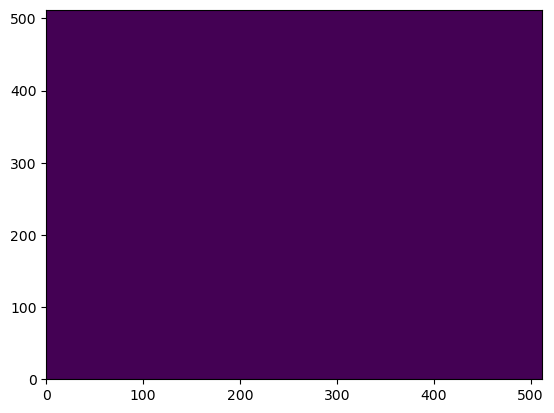

In [19]:
plt.pcolormesh(mask[-5])

Finally, its time to remove the table. Note that the center of mass of the table is always lower than the two lungs. As such, we simply need to delete the volume with the lowest center of mass in $y$ to delete the table:

In [20]:
labels = label(mask[170], background=0)

In [31]:
# plt.pcolormesh(labels)
# plt.colorbar()

Finally, we can expand the area of the lungs a little bit by growing the border. For this, we can use the `binary_dilation` function:

In [37]:
from scipy.ndimage import binary_dilation
mask_new = binary_dilation(mask, iterations=6)

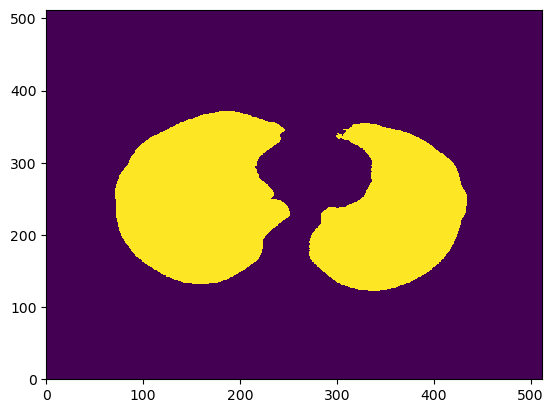

In [38]:
plt.pcolormesh(mask_new[140])

In [39]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [40]:
# Affinitás mátrix létrehozzása
affine = np.eye(4)

# A skála faktor beállítása
scaling_factor = 1.5
affine[0, 0] *= scaling_factor

# NIfTI kép létrehozzása
img_out = nib.Nifti1Image(mask.astype(np.uint8), affine)

# NIfTI kép elmentése
nib.save(img_out, 'output_mask.nii')
